In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from transformers import ViTModel, ViTFeatureExtractor
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Concatenate, Input, BatchNormalization, ReLU, Conv2D, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Pooja Sri L\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Directories for the ISIC Skin Cancer dataset
train_dir = r"C:\Users\Pooja Sri L\OneDrive\Desktop\archive\Skin cancer ISIC The International Skin Imaging Collaboration\Train"
test_dir = r"C:\Users\Pooja Sri L\OneDrive\Desktop\archive\Skin cancer ISIC The International Skin Imaging Collaboration\Test"

In [3]:

# Load the dataset and prepare dataframe
train_df = pd.DataFrame(columns=['image_path', 'label'])
test_df = pd.DataFrame(columns=['image_path', 'label'])

In [4]:
# Prepare DataFrame
for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        train_df = pd.concat([train_df, pd.DataFrame({'image_path': [image_path], 'label': [label]})], ignore_index=True)


In [5]:
for label, directory in enumerate(os.listdir(test_dir)):
    for filename in os.listdir(os.path.join(test_dir, directory)):
        image_path = os.path.join(test_dir, directory, filename)
        test_df = pd.concat([test_df, pd.DataFrame({'image_path': [image_path], 'label': [label]})], ignore_index=True)


In [6]:
# Combine train and test datasets
df = pd.concat([train_df, test_df], ignore_index=True)
del train_df, test_df

In [7]:
# Label mapping
labels = os.listdir(train_dir)
label_map = {i: label for i, label in enumerate(labels)}
num_classes = len(label_map)

In [8]:
# Limit number of images per class
max_images_per_class = 2500
df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)


C:\Users\Pooja Sri L\AppData\Local\Temp\ipykernel_11508\1896713045.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)


In [9]:
# Function to resize images
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100, 75)))


In [10]:
# Resize images using concurrent futures
import concurrent.futures
import multiprocessing

max_workers = multiprocessing.cpu_count()
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

df['image'] = image_arrays
del image_arrays

In [11]:
# Data Augmentation: MixUp
def mixup(x, y, alpha=0.2):
    batch_size = tf.shape(x)[0]
    lam = np.random.beta(alpha, alpha)
    index = tf.random.shuffle(tf.range(batch_size))
    mixed_x = lam * x + (1 - lam) * tf.gather(x, index)
    mixed_y = lam * y + (1 - lam) * tf.gather(y, index)
    return mixed_x, mixed_y

In [12]:
# Train, Test, and Validation Split
features = df.drop(columns=['label', 'image_path'], axis=1)
target = df['label']
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, shuffle=True)

x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())


In [13]:
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_test_mean) / x_test_std

y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.20, shuffle=True)

x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [14]:
# Vision Transformer (ViT)
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224')

# EfficientNet
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(75, 100, 3))


C:\Users\Pooja Sri L\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\Pooja Sri L\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Pooja Sri L\.cache\huggingface\hub\models--google--vit-base-patch16-224. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you e

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [17]:
def multi_scale_fusion(input_tensor):
    # First branch: Regular convolution and pooling
    branch_1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_tensor)
    branch_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(branch_1)  # Downsample by 2

    # Second branch: Different convolution but same pooling to ensure shape matches
    branch_2 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_tensor)
    branch_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(branch_2)  # Also downsample by 2

    # Concatenate after ensuring same spatial dimensions
    fused = Concatenate()([branch_1, branch_2])
    
    return fused

# Attention Mechanism: Squeeze-and-Excitation (SE) block
def se_block(input_tensor, reduction=16):
    channels = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = tf.keras.layers.Reshape((1, 1, channels))(se)
    se = Dense(channels // reduction, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    return Multiply()([input_tensor, se])

In [25]:
# Assemble EfficientNet and ViT with Multi-Scale Fusion and Attention

from tensorflow.keras.regularizers import l2
input_cnn = Input(shape=(75, 100, 3), name='input_cnn')
cnn_x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False)(input_cnn)
cnn_x = BatchNormalization()(cnn_x)
cnn_x = ReLU(6.)(cnn_x)
cnn_x = multi_scale_fusion(cnn_x)
cnn_x = se_block(cnn_x)
cnn_x = GlobalAveragePooling2D()(base_model.output)
cnn_x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(cnn_x)
cnn_x = Dropout(0.5)(cnn_x)
cnn_output = Dense(num_classes, activation='softmax')(cnn_x)

In [26]:
# Model Definition
combined_model = Model(inputs=base_model.input, outputs=cnn_output, name='combined_model')
combined_model.summary()

# Compile the model with AdamW optimizer
combined_model.compile(optimizer=AdamW(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks: ReduceLROnPlateau for Learning Rate Scheduling
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

Model: "combined_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 75, 100, 3)        │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 75, 100, 3)        │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 75, 100, 3)        │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 75, 100, 3)        │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 77, 101, 3)        │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 38, 50, 32)        │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 38, 50, 32)        │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 38, 50, 32)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 38, 50, 32)        │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 38, 50, 32)        │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 38, 50, 32)        │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,379,820 (16.71 MB)

 Trainable params: 4,337,797 (16.55 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [33]:


from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data generator with valid augmentations
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],  # Valid brightness augmentation
    fill_mode='nearest'
)

# Fit the data generator on the training data (optional but helps with feature scaling)
datagen.fit(x_train)




In [38]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))
epochs=500
# Pass the class_weights to the fit function
history = combined_model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=epochs,
    steps_per_epoch=len(x_train) // 32,
    validation_data=(x_validate, y_validate),
    callbacks=[reduce_lr],
    class_weight=class_weights  # Add class weights here
)

Epoch 1/500


C:\Users\Pooja Sri L\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 58s 527ms/step - accuracy: 0.7303 - loss: 0.9518 - val_accuracy: 0.6207 - val_loss: 1.5414 - learning_rate: 1.0000e-04
Epoch 2/500
 1/47 ━━━━━━━━━━━━━━━━━━━━ 25s 562ms/step - accuracy: 0.7500 - loss: 0.6769

C:\Users\Pooja Sri L\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7500 - loss: 0.6769 - val_accuracy: 0.6233 - val_loss: 1.5402 - learning_rate: 1.0000e-04
Epoch 3/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 472ms/step - accuracy: 0.7524 - loss: 0.8414 - val_accuracy: 0.6286 - val_loss: 1.5317 - learning_rate: 1.0000e-04
Epoch 4/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6875 - loss: 0.8257 - val_accuracy: 0.6260 - val_loss: 1.5303 - learning_rate: 1.0000e-04
Epoch 5/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 459ms/step - accuracy: 0.7574 - loss: 0.7834 - val_accuracy: 0.6207 - val_loss: 1.5643 - learning_rate: 1.0000e-04
Epoch 6/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7500 - loss: 0.7574 - val_accuracy: 0.6180 - val_loss: 1.5658 - learning_rate: 1.0000e-04
Epoch 7/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 494ms/step - accuracy: 0.7843 - loss: 0.7488 - val_accuracy: 0.6207 - val_loss: 1.5453 - learning_rate: 1.0000e-04
Epoch 8/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5625

KeyboardInterrupt: 

In [39]:
# Unfreeze the last few layers of MobileNet
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Re-compile the model after unfreezing layers
combined_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step


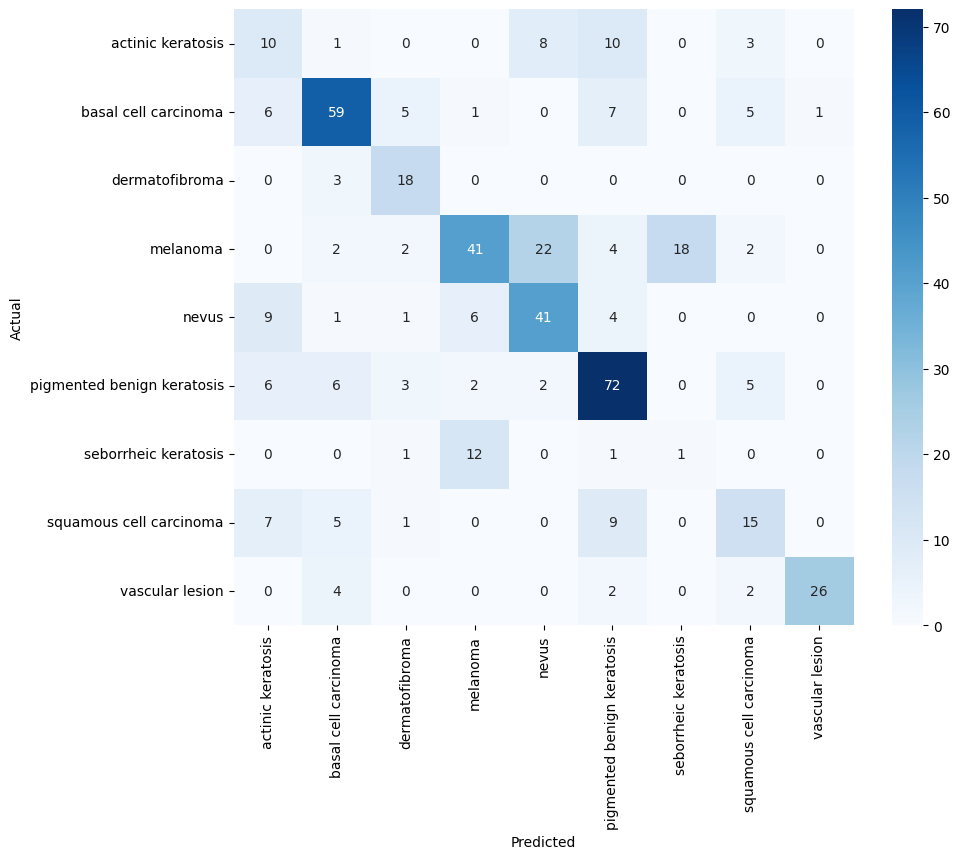

                            precision    recall  f1-score   support

         actinic keratosis       0.26      0.31      0.29        32
      basal cell carcinoma       0.73      0.70      0.72        84
            dermatofibroma       0.58      0.86      0.69        21
                  melanoma       0.66      0.45      0.54        91
                     nevus       0.56      0.66      0.61        62
pigmented benign keratosis       0.66      0.75      0.70        96
      seborrheic keratosis       0.05      0.07      0.06        15
   squamous cell carcinoma       0.47      0.41      0.43        37
           vascular lesion       0.96      0.76      0.85        34

                  accuracy                           0.60       472
                 macro avg       0.55      0.55      0.54       472
              weighted avg       0.62      0.60      0.60       472



In [40]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = combined_model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_map.values(), yticklabels=label_map.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=label_map.values()))


In [41]:
# Random Prediction
import random
random_indices = random.sample(range(len(x_test)), 5)
x_random = x_test[random_indices]
y_random = y_test[random_indices]

def predict_single(model, x_random, y_random, label_map):
    predictions = model.predict(x_random)
    for i in range(len(x_random)):
        print(f"Actual: {label_map[np.argmax(y_random[i])]}")
        print(f"Predicted: {label_map[np.argmax(predictions[i])]}")

predict_single(combined_model, x_random, y_random, label_map)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Actual: basal cell carcinoma
Predicted: squamous cell carcinoma
Actual: vascular lesion
Predicted: vascular lesion
Actual: vascular lesion
Predicted: vascular lesion
Actual: pigmented benign keratosis
Predicted: pigmented benign keratosis
Actual: basal cell carcinoma
Predicted: pigmented benign keratosis
